In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import json
from pathlib import Path 

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _aggregation_helpers import flexible_aggregate

In [14]:
dates = pd.date_range('2022-07', '2024-07', freq='m').strftime('%Y-%m')

In [15]:
# dates = pd.date_range('2022-07', '2024-07', freq='m').strftime('%Y-%m')

path = Path.cwd().parent / 'results'

def agg_month(date):
    """month to aggregate"""

    if isinstance(date, pd.Timestamp):
        date = date.strftime('%Y-%m')

    ts = str(int(pd.Timestamp(date).timestamp()))

    hierarchy = ['daily', 'half-hourly', 'periods']
    gathered_files = None

    def should_be_added(fn, nonadds):

        if nonadds is not None:
            condition2 = lambda fn: fn.startswith(nonadds)
        else:
            condition2 = lambda _: False

        return (fn.startswith(date) + condition2(fn)) == 1

    for level in hierarchy:

        if gathered_files is not None:
            cleaned = tuple(map(lambda entry: entry.split('.')[0], gathered_files))
        else:
            cleaned = None

        level_files = tuple([fn for fn in os.listdir(path / level) if should_be_added(fn, cleaned)])

        if gathered_files is None:
            gathered_files = level_files
        else:     
            gathered_files += level_files


    total_periods = 48 * len(
        pd.date_range(
            pd.Timestamp(date),
            pd.Timestamp(date) + pd.offsets.MonthEnd(1),
            freq='d'
        )
    )

    num_period_mapper = {
        12: total_periods,
        15: 48,
        17: 1,
        18: 1,
    }
    num_path_mapper = {
        12: 'daily',
        15: 'half-hourly',
        17: 'periods',
        18: 'periods',
    }

    covered_periods = pd.Series(gathered_files).map(len).map(num_period_mapper).sum()
    covered_share = covered_periods / total_periods
    
    def get_json(fn):
        with open(fn, 'r') as f:
            return json.load(f)

    results = {}
    
    for d, fn in zip(pd.Series(gathered_files).map(len).map(num_path_mapper), gathered_files):
        results.update(get_json(path / d / fn))

    return {ts: flexible_aggregate(results)}, covered_share
    # return covered_share

monthly_results = {}
shares = pd.Series(index=dates)

from tqdm import tqdm

for date in tqdm(dates):
    result, share = agg_month(date)

    shares[date] = share
    monthly_results.update(result)

# total = agg_month(dates[1])

100%|██████████| 24/24 [04:59<00:00, 12.48s/it]


In [17]:
y1_start = int(pd.Timestamp('2022-07').timestamp())
y2_start = int(pd.Timestamp('2023-07').timestamp())

yearly_results = {
    str(y1_start): flexible_aggregate({k: v for k, v in monthly_results.items() if int(k) < y2_start}),
    str(y2_start): flexible_aggregate({k: v for k, v in monthly_results.items() if int(k) >= y2_start}),
}

In [6]:
# with open('monthly_aggregate.json', 'w') as f:
#     json.dump(monthly_results, f)

<AxesSubplot:>

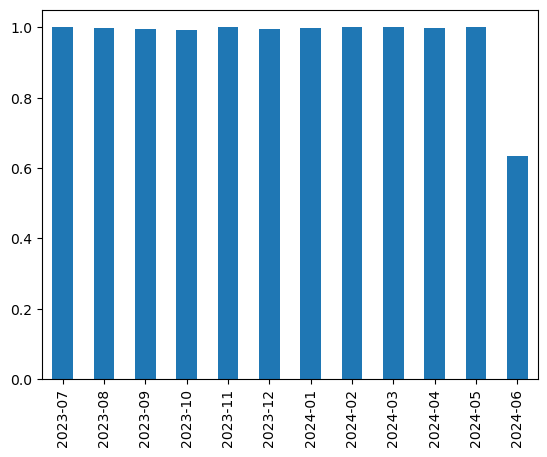

In [7]:
shares.plot.bar()

In [8]:
total = flexible_aggregate(monthly_results)

In [9]:

for l in list(total):
    ts = total[l]

    i = ts['globals']['variables']

    ts = sum([item for key, item in i.items() if 'savings' in key])

    print(l, ts*1e-9)

national 0.0
nodal 3.0315734846142846
eso 2.096869673933436


In [10]:
list(total['nodal']['globals']['variables'])

['wholesale_cost',
 'balancing_cost',
 'congestion_rent',
 'cfd_cost',
 'wholesale_cost_savings',
 'balancing_cost_savings',
 'congestion_rent_savings',
 'cfd_cost_savings']

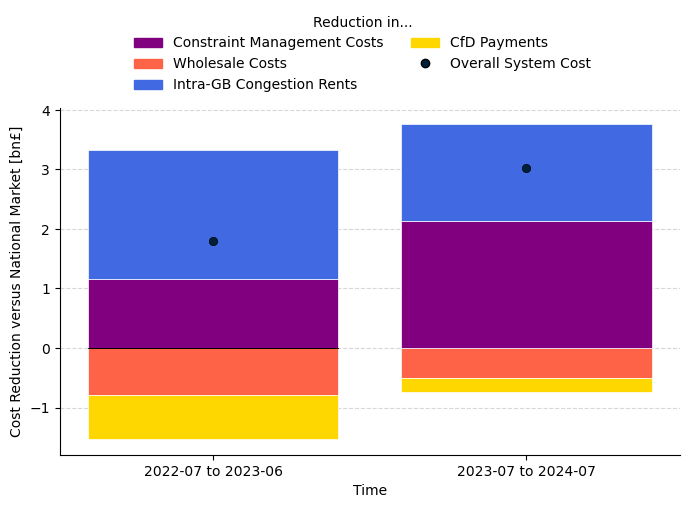

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 4.5))
fig, ax = plt.subplots(1, 1, figsize=(8, 4.5))

colors = {
    # 'balancing_cost_savings': '#c00000',
    'balancing_cost_savings': 'purple',
    # 'wholesale_cost_savings': '#3fd0ff',
    'wholesale_cost_savings': 'tomato',
    # 'congestion_rent_savings': '#1bb680',
    'congestion_rent_savings': 'royalblue',
    # 'cfd_cost_savings': '#5781a6',
    # 'cfd_cost_savings': 'teal',
    'cfd_cost_savings': 'gold',
    'total': '#00213b',
}
cmapper = {
    'wholesale': 'tomato',
    'balancing': 'purple',
    'cfd': 'teal',
    'congestion_rent': 'royalblue',
}

nice_names = {
    'balancing_cost_savings': 'Constraint Management Costs',
    'wholesale_cost_savings': 'Wholesale Costs',
    'congestion_rent_savings': 'Intra-GB Congestion Rents',
    'cfd_cost_savings': 'CfD Payments',
}

quants = list(nice_names)

l = 'nodal'
# l = 'eso'

ttt = 0
plotstart = pd.Timestamp('2022-07')

# for i, data in monthly_results.items():
for (i, data), dt in zip(yearly_results.items(), ['2022-07 to 2023-06', '2023-07 to 2024-07']):

    if pd.Timestamp.fromtimestamp(int(i)) < plotstart:
        continue

    data = (
        pd.Series(
            data[l]['globals']['variables']
        )
        .loc[quants]
        .mul(1e-9)
        .rename(
            # (dt := pd.Timestamp.fromtimestamp(int(i)).strftime('%Y-%m'))
            dt
        )
    )

    ttt += data.sum()

    neg = data[data < 0]
    pos = data[data > 0]

    negcum = neg.cumsum()
    poscum = pos.cumsum()

    total_b = data.sum()

    bar_kwargs = dict(    
        edgecolor='white',
        linewidth=0.5,
    )

    for q, val in neg.items():
        ax.bar(dt, val, color=colors[q], bottom=negcum[q] - val, **bar_kwargs)
    
    for q, val in pos.items():
        ax.bar(dt, val, color=colors[q], bottom=poscum[q] - val, **bar_kwargs)

    ax.scatter([dt], [total_b], color=colors['total'], zorder=10, edgecolor='black', linewidth=0.5)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Cost Reduction versus National Market [bn£]')

for q, col in nice_names.items():
    ax.bar(0, 0, color=colors[q], label=nice_names[q], edgecolor='black', linewidth=0.5)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

handles, labels = [], []

# handles.append(Line2D([0], [0], color='w', lw=0, label=''))

nice_lname = {
    'nodal': 'Nodal Layout',
    'eso': 'Zonal Layout',
}
# labels = [f'{nice_lname[l]} Reduction in...']
# labels = ['Reduction in...']
labels = []

for i, (n, nn) in enumerate(nice_names.items()):
    handles.append(Patch(color=colors[n]))
    labels.append(nn)

    # if i == 1:
    # handles.append(Line2D([0], [0], color='w', lw=0, label=''))
    #     labels.append('')


handles.append(Line2D([0], [0], color='w', marker='o', label='', markerfacecolor=colors['total'], markeredgecolor='black'))
labels.append('Overall System Cost')

# if l == 'eso':
#     bbox_to_anchor = (0.25, 0.9)
# else:
#     bbox_to_anchor = (0.23, 1.01)

bbox_to_anchor = (0.1, 1.01)

ax.legend(
    handles, labels,
    title='Reduction in...',
    # loc='lower right',
    # bbox_to_anchor=(1, 0.39),
    bbox_to_anchor=bbox_to_anchor,
    ncol=2,
    frameon=False,
)

# ax.text(
#     '2024-03', -0.15, f'{nice_lname[l]}',
# fontweight='bold', fontsize=12, color='black', ha='left', va='center',
# )

ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.tick_params(axis='x', labelrotation=0)
ax.set_xlabel('Time')
ax.set_axisbelow(True)

# ax.set_ylim(-0.29, 0.59)

plt.savefig(f'monthly_totals_{l}.png', dpi=300, bbox_inches='tight')

plt.show()

In [3]:
a = 'nifduvf'

# a.__contains__('if')
'if' in a

True

In [72]:
# monthly_results[list(monthly_results.keys())[0]]

with open('month_raw.json', 'w') as f:
    json.dump(monthly_results, f)


In [24]:
len(pd.date_range('2022-07', '2023-06-01', freq='d')) * 48

16128

In [1]:
import json
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

In [2]:
path = Path.cwd().parent / 'results'
# with open(path / 'periods' / '2023-04-05_19.json', 'r') as f:
    # data = json.load(f)

In [3]:
# pprint(data[list(data)[0]]['national']['globals']['variables'])
# pprint(data[list(data)[0]]['eso']['globals']['variables'])
# pprint(data[list(data)[0]]['nodal']['globals']['variables'])

In [4]:
path = Path.cwd().parent / 'resources' / 'live_data'

In [20]:
n1 = pypsa.Network(path / '2024-04-05_19' / 'network_s_nodal_solved.nc')
n2 = pypsa.Network(path / '2024-04-05_19' / 'network_s_eso_solved.nc')
n3 = pypsa.Network(path / '2023-04-05_19' / 'network_s_eso_solved.nc')
n4 = pypsa.Network(path / '2023-04-05_19' / 'network_s_nodal_solved.nc')

Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_eso_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_eso_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads


In [6]:
import yaml

with open(Path.cwd().parent / 'config' / 'config.yaml', 'r') as f:
    config = yaml.safe_load(f)['boundaries']

In [7]:
getflow = lambda n: n.lines_t.p0.iloc[0]

In [8]:
def reverse_dict_of_lists(d):
    return {v: k for k, vs in d.items() for v in vs}

bs_nodal = reverse_dict_of_lists(config['nodal'])
bs_eso = reverse_dict_of_lists(config['eso'])

In [9]:

def get_boundary_flows(n):

    if len(n.buses) > 200:
        mode = 'nodal'
    else:
        mode = 'eso'

    return pd.concat((
        n.lines.loc[:, 's_nom'].rename('nom'),
        getflow(n).rename('flow').abs(),
        pd.Series(n.lines.index, n.lines.index, name='b')
            .apply(lambda x: globals()['bs_'+mode].get(int(x), np.nan)),
    ), axis=1).dropna().groupby('b').sum()


print('nodal')
print(get_boundary_flows(n1))

print('zonal')
print(get_boundary_flows(n2))

nodal
                  nom         flow
b                                 
FLOWSTH  10494.274141  1419.584783
SCOTEX    4496.575716  3606.315143
SEIMP     6002.792733  3566.627694
SSE-SP    2898.638815  2695.125685
SSHARN    7478.443902  2885.233573
SWALEX    6792.410447  1532.235491
zonal
                  nom         flow
b                                 
FLOWSTH  10494.274141  2031.922057
SCOTEX    4496.575716  3394.300407
SEIMP     6000.022144  4477.323399
SSE-SP    2900.448635  2900.448635
SSHARN    7478.443902  2673.218837
SWALEX   13584.820894  2684.064235


In [10]:
#  n1.lines.sort_values(by='s_nom', ascending=False)
getgen = lambda n: pd.concat((n.generators_t.p.iloc[0].rename('dispatch'), n.generators[['carrier', 'p_nom', 'marginal_cost']]), axis=1)

print('eso')
print((g1 := getgen(n1).groupby('carrier').sum().sort_values('dispatch')))
print('nodal')
print((g2 := getgen(n2).groupby('carrier').sum().sort_values('dispatch')))

comp = 'dispatch'
print(g1.loc[g1[comp] != g2[comp].loc[g1.index]])
print(g2.loc[g1[comp] != g2[comp].loc[g1.index]])

print('nodal cost: ', g2['dispatch'].mul(g2['marginal_cost']).sum())
print('zonal cost: ', g1['dispatch'].mul(g1['marginal_cost']).sum())

eso
                         dispatch    p_nom  marginal_cost
carrier                                                  
powerstation             0.000000    185.0      91.334573
cascade                  0.000000     45.0     100.000000
PV                      49.000000     49.0       0.010000
solar power station     50.000000     50.0       0.000000
gas turbine             60.000000    120.0     131.929044
hydro                   61.000000    229.0     140.000000
floating wind           67.000000     67.0       0.020000
gas-fired               96.000000     96.0     126.778656
hydro-scheme           104.666525    417.0     140.000000
coal                   130.000000   1247.0     417.423723
CHP                    148.000000    273.0     189.249756
battery                193.000000    228.0     280.000000
CCGT                   300.000000   3989.0     813.522267
wind                   570.000000    574.0       0.180000
PHS                   1030.000000   1030.0     140.000000
onwind    

In [11]:
g1 = getgen(n1)
g2 = getgen(n2)

In [12]:
g1['cost'] = g1['dispatch'].mul(g1['marginal_cost'])
g2['cost'] = g2['dispatch'].mul(g2['marginal_cost'])

In [13]:
pd.concat((
    g1.groupby('carrier')['cost'].sum().sort_values().rename('nodal'),
    g2.groupby('carrier')['cost'].sum().sort_values().rename('zonal'))
    , axis=1)

,nodal,zonal
carrier,,
powerstation,0.000000,0.000000
cascade,0.000000,0.000000
solar power station,0.000000,0.000000
PV,0.490000,0.490000
floating wind,0.670000,0.670000
wind,5.700000,5.700000
onwind,15.500000,15.500000
offwind,106.490000,106.490000
hydro,1220.000000,1664.804645


2023


Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_eso_solved.nc has buses, carriers, generators, lines, links, loads


nodal total cost:  1901866.3339926014
nodal market cost:  3595639.151057183
zonal total cost:  1913519.0100169072
zonal market cost:  3336968.0670814747


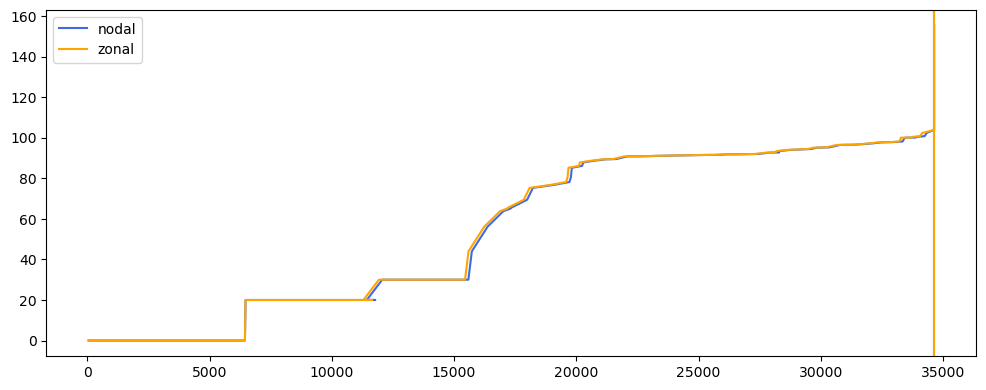

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4.5))

year = '2023'
get_model = lambda year, l: pypsa.Network(path / f'{year}-04-05_19' / f'network_s_{l}_solved.nc')

print(year)

for n, c in zip(
    [get_model(year, 'nodal'), get_model(year, 'eso')],
    ['royalblue', 'orange', 'red']
    ):

    if len(n.buses) > 200:
        name = 'nodal'
    else:
        name = 'zonal'

    g = getgen(n).sort_values('marginal_cost')

    g['bus'] = n.generators.bus

    g = g.loc[g['bus'] != '']
    cumgen = g['dispatch'].cumsum()

    g['marginal_price'] = g['bus'].apply(lambda b: n.buses_t.marginal_price.iloc[0].loc[b])

        
    ax.plot(cumgen, g['marginal_cost'], color=c)

    ax.axvline(n.loads.p_set.sum(), color=c, label=name)
    print(f'{name} total cost: ', g['dispatch'].mul(g['marginal_cost']).sum())
    print(f'{name} market cost: ', g['dispatch'].mul(g['marginal_price']).sum())

    g['cost'] = g['dispatch'].mul(g['marginal_cost'])
    # print(g.groupby('carrier')['cost'].sum().sort_values())

ax.legend()
plt.show()